In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from python.analysis import Plots
from python.analysis.shower_merging import SetPlotStyle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from rich import print

SetPlotStyle()

In [6]:
df = pd.read_hdf("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5")
print(df)

reco_energy  true_energy
0       133.802572   268.863259
1       127.616533  1343.636619
2       104.872036   129.958027
3        75.675744    89.715949
4       563.250869   770.033836
...            ...          ...
16383   545.426464   531.016507
16384   516.226603   335.723310
16385   565.426627   385.056909
16386    35.134860    90.807447
16387   246.498951   420.794547

[16388 rows x 2 columns]

[   0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800. 2000.]

reco_energy  true_energy
0       133.802572   268.863259
1       127.616533  1343.636619
2       104.872036   129.958027
3        75.675744    89.715949
4       563.250869   770.033836
...            ...          ...
16383   545.426464   531.016507
16384   516.226603   335.723310
16385   565.426627   385.056909
16386    35.134860    90.807447
16387   246.498951   420.794547

[16388 rows x 2 columns]

[0.85287011] [[0.02743517]]

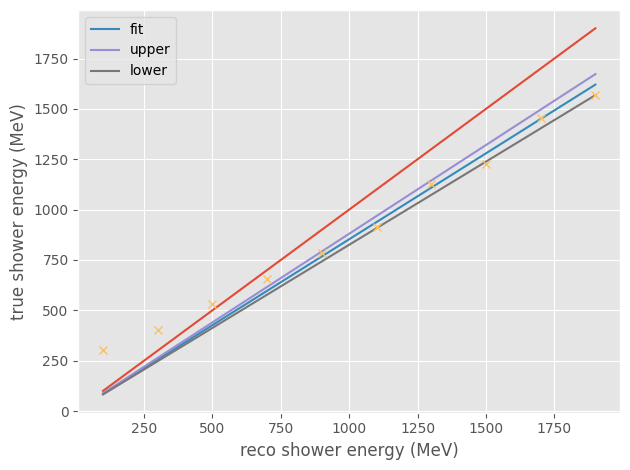

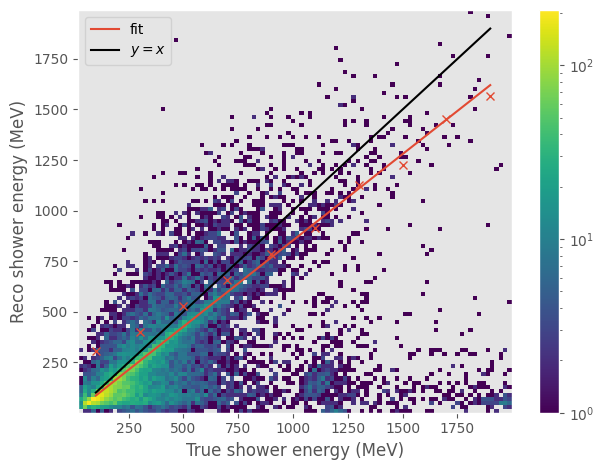

In [30]:
def lineI(x, m):
    return m * x

bins = np.linspace(0, 2000, 11)
print(bins)
print(df)


binned_data = []
for i in range(1, len(bins)):
    data = df[(df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])]
    binned_data.append(data[data.true_energy < 2000])


x = (bins[1:] + bins[:-1]) / 2

y = np.array([d.true_energy.mean() for d in binned_data])

popt, pcov = curve_fit(lineI, x, y)

print(popt, pcov**0.5)

err = np.array([pcov[i][i] for i in range(len(popt))])**0.5

Plots.Plot(x, x)
Plots.Plot(x, lineI(x, *popt), newFigure = False, label = "fit")
Plots.Plot(x, lineI(x, *(popt + err)), newFigure = False, label = "upper")
Plots.Plot(x, lineI(x, *(popt - err)), newFigure = False, label = "lower")

Plots.Plot(x, y, marker = "x", linestyle = "", xlabel = "reco shower energy (MeV)", ylabel = "true shower energy (MeV)", newFigure = False)

Plots.PlotHist2D(df.true_energy, df.reco_energy, x_range = [0, 2000], y_range = [0, 2000])
Plots.Plot(x, lineI(x, *popt), newFigure = False, label = "fit", color = "C0")
Plots.Plot(x, x, newFigure = False, color = "black", label = "$y = x$")
Plots.Plot(x, y, marker = "x", linestyle = "", xlabel = "True shower energy (MeV)", ylabel = "Reco shower energy (MeV)", newFigure = False, color = "C0")

correction factor : 0.8528701062421319

mean shower energy fractional error: -0.21781160487353243 +- 0.5460151496829554

mean shower energy fractional error after correction: -0.08287511849500513 +- 0.6402090373278253

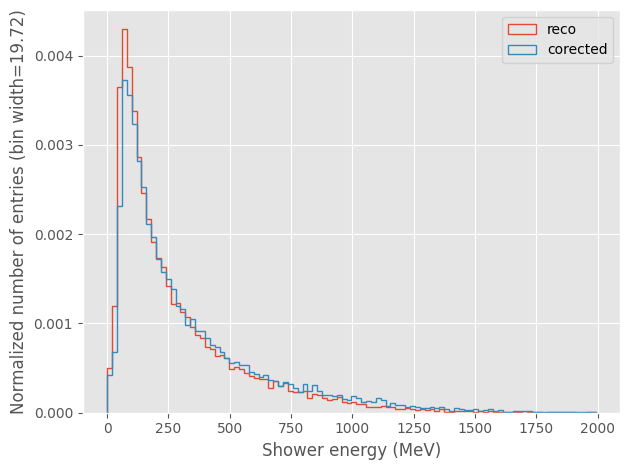

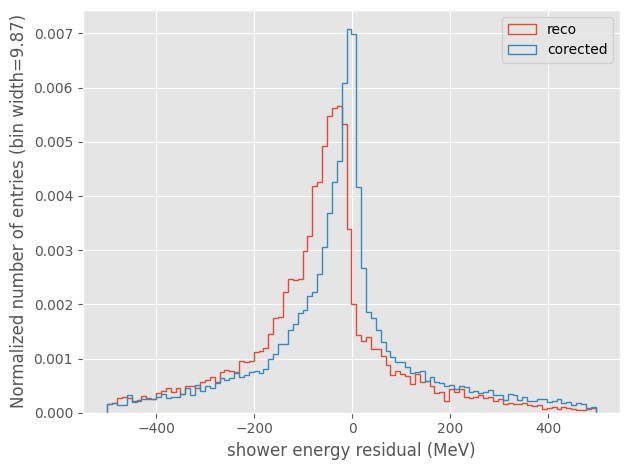

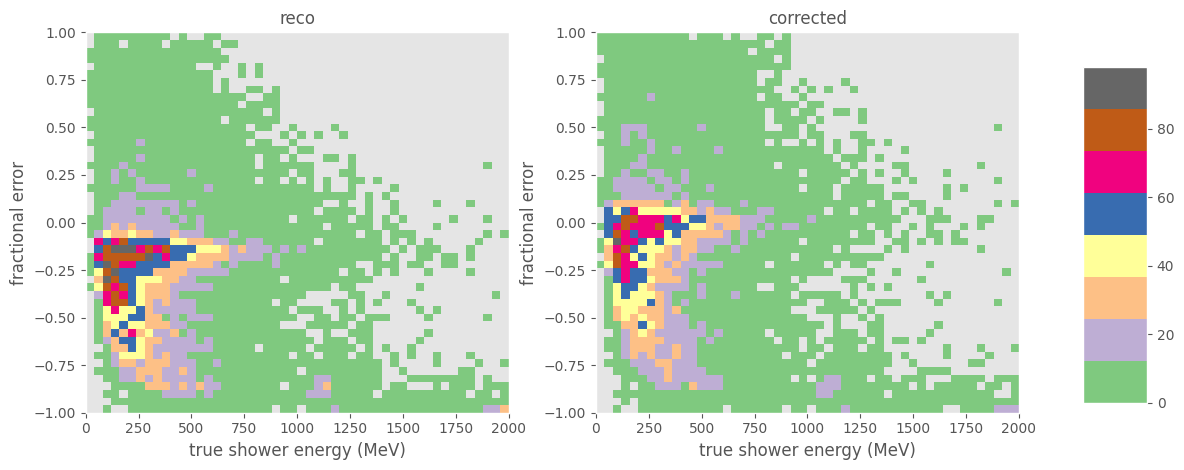

In [31]:

def figure_dimensions(x, orientation : str = "horizontal"):
    nearest_square = int(np.ceil(x**0.5))

    if x < 4:
        dim = (1, x)
    elif (nearest_square - 1) * nearest_square >= x:
        dim = ((nearest_square - 1), nearest_square)
    else:
        dim = (nearest_square, nearest_square)
    
    if orientation == "vertical":
        dim = dim[::-1]
    return dim


def Hist2DComparison(x, y, x_range, y_range, x_labels = None, y_labels = None, titles = None, bins = 50, cmap = "plasma", func = None, orientation = "horizontal"):
    if x_labels is None: x_labels = [""]*len(x)
    if y_labels is None: y_labels = [""]*len(y)
    if titles is None: titles = [""] * len(x)

    dim = figure_dimensions(len(x), orientation)
    fig_size = (6.4 * dim[1], 4.8 * dim[0])
    ranges = [x_range, y_range]

    vmax = 0
    for xs, ys in zip(x, y):
        h, _, _ = np.histogram2d(xs, ys, bins, range = ranges)
        vmax = max(vmax, np.max(h))

    fig = plt.figure(figsize = fig_size)
    for i in range(len(x)):
        plt.subplot(*dim, i + 1)
        if func is None:
            _, _, _, im = plt.hist2d(x[i], y[i], bins, range = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        else:
            _, _, _, im = func(x = x[i], y = y[i], bins = bins, ranges = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        plt.xlabel(x_labels[i])
        plt.ylabel(y_labels[i])
        plt.title(titles[i])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, cax = cbar_ax)

# corrected_energy = lineI(df.reco_energy, *popt)
corrected_energy = df.reco_energy / popt[0]

fe = (df.reco_energy / df.true_energy) - 1
fec = (corrected_energy / df.true_energy) - 1

print(f"correction factor : {popt[0]}")
print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")

Plots.PlotHistComparison([df.reco_energy, corrected_energy], labels = ["reco", "corected"], xRange = [0, 2000], xlabel = "Shower energy (MeV)")
Plots.PlotHistComparison([df.reco_energy - df.true_energy, corrected_energy - df.true_energy], labels = ["reco", "corected"], xRange=[-500, 500], xlabel = "shower energy residual (MeV)")

Hist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 2000], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["true shower energy (MeV)"]*2, y_labels = ["fractional error"]*2, titles = ["reco", "corrected"])